In [308]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torchvision
from torchvision import transforms

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader


In [309]:
class MyCropFunction:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        
    def __call__(self, x):
        return transforms.functional.crop(x, 0, 0, self.height, self.width)

transform = torchvision.transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(),
    MyCropFunction(height=83, width=83),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomRotation((0, 180)),
    transforms.ToTensor(),
])

In [310]:
train_images = torchvision.datasets.ImageFolder(root="images/train", transform=transform)
validation_images = torchvision.datasets.ImageFolder(root="images/validation", transform=transform)
test_images = torchvision.datasets.ImageFolder(root="images/test", transform=transform)

In [311]:
BATCH_SIZE = 64

In [312]:
train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
validation_loader = DataLoader(
    validation_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

(1, 83, 83)


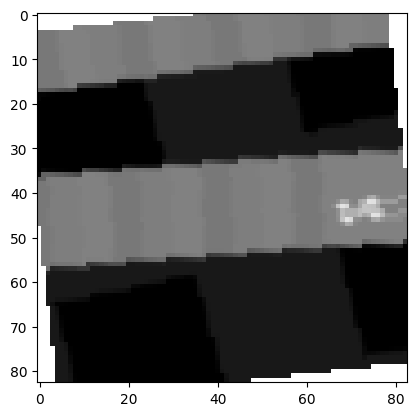

In [313]:
image = train_loader.dataset[55][0].numpy()
print(image.shape)
plt.imshow(image[0], cmap="Greys")

In [314]:
def dim_encoder(Hin, Win, padding, dilation, kernel_size, stride):
    Hout = (Hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1
    Wout = (Win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1
    return math.floor(Hout), math.floor(Wout)

Hin, Win = 83, 83
Hout, Wout = dim_encoder(Hin, Win, padding=(1, 1), dilation=(1, 1), kernel_size=(3, 3), stride=(2, 2))
Hout, Wout = dim_encoder(Hout, Wout, (1, 1), (1, 1), (3, 3), (2, 2))
Hout, Wout = dim_encoder(Hout, Wout, (0, 0), (1, 1), (3, 3), (2, 2))

print(Hout, Wout)

def dim_decoder(Hin, Win, padding, dilation, kernel_size, stride, outpadding):
    Hout = (Hin-1) * stride[0] - 2 * padding[0] + dilation[0] * (kernel_size[0] - 1) + outpadding[0] + 1
    Wout = (Win-1) * stride[1] - 2 * padding[1] + dilation[1] * (kernel_size[1] - 1) + outpadding[1] + 1
    return Hout, Wout

Hin, Win = 10, 10
Hout, Wout = dim_decoder(Hin, Win, padding=(1, 1), dilation=(1, 1), kernel_size=(3, 3), stride=(2, 2), outpadding=(0, 0))

print(Hout, Wout)
    


10 10
19 19


In [315]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.encoder_lin = nn.Sequential(
            nn.Linear(10 * 10 * 256, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim),
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        
        return x

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 10 * 10 * 256)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 10, 10))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x


In [316]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 50

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=50, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=102400, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(1024, 10, 10))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(1024, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
)

In [317]:

### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # print(image_batch.shape)
        # Encode data
        encoded_data = encoder(image_batch)
        # print(encoded_data.shape)
        # Decode data
        decoded_data = decoder(encoded_data)
        # print(decoded_data.shape)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [318]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [319]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      index = np.random.randint(0, len(test_images))
      img = test_images[index][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      image = img.cpu().squeeze().numpy()
      # print(image.shape)
      image = np.moveaxis(image, 0, -1)
      # print(image.shape)
      plt.imshow(image.astype(np.float32))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      rec_image = rec_img.cpu().squeeze().numpy()
      # print(rec_image.shape)
      rec_image = np.moveaxis(rec_image, 0, -1)
      # print(rec_image.shape)
      plt.imshow(rec_image.astype(np.float32))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()  


 EPOCH 1/100 	 train loss 0.6218476295471191 	 val loss 0.06841835379600525


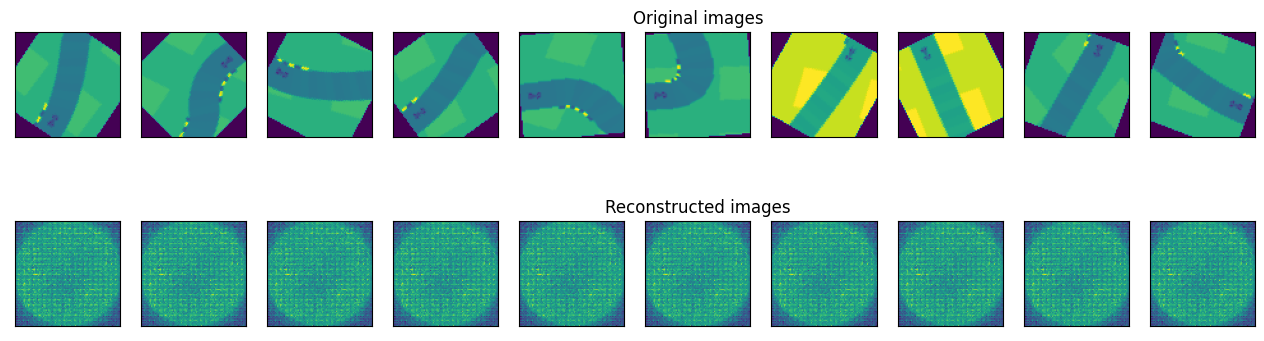


 EPOCH 2/100 	 train loss 0.03079652227461338 	 val loss 0.028107592836022377

 EPOCH 3/100 	 train loss 0.027018021792173386 	 val loss 0.02738829515874386

 EPOCH 4/100 	 train loss 0.027009187266230583 	 val loss 0.02886899560689926

 EPOCH 5/100 	 train loss 0.026317048817873 	 val loss 0.030062999576330185

 EPOCH 6/100 	 train loss 0.025780554860830307 	 val loss 0.031252216547727585

 EPOCH 7/100 	 train loss 0.022728875279426575 	 val loss 0.028654921799898148

 EPOCH 8/100 	 train loss 0.020657148212194443 	 val loss 0.02510181814432144

 EPOCH 9/100 	 train loss 0.020202986896038055 	 val loss 0.027347978204488754

 EPOCH 10/100 	 train loss 0.01597244292497635 	 val loss 0.015996573492884636

 EPOCH 11/100 	 train loss 0.013814915902912617 	 val loss 0.013747338205575943


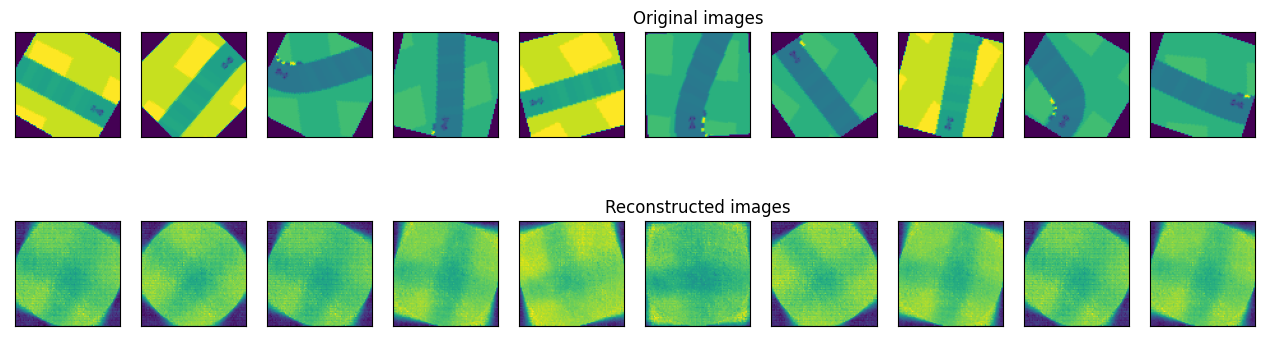

KeyboardInterrupt: 

In [320]:
num_epochs = 100
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if epoch % 10 == 0:
      plot_ae_outputs(encoder,decoder,n=10)

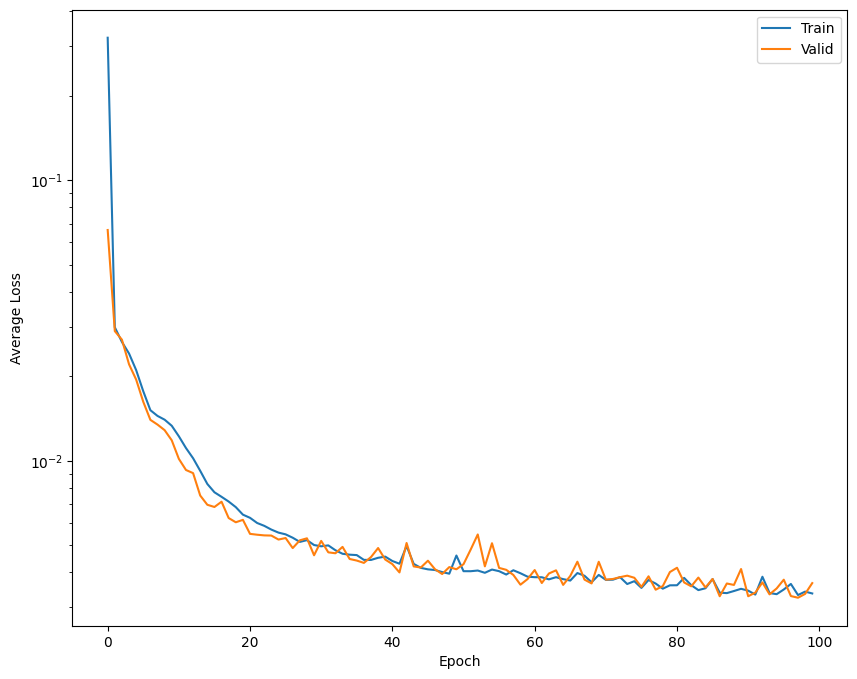

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
# torch.save(encoder.state_dict(), "encoder")
# torch.save(decoder.state_dict(), "decoder")